# Functions

In [84]:
import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)

In [85]:
from utils.environment import setup_data_vars
setup_data_vars()

## Calculate Metrics

In [86]:
def get_id_from_path(path: str, needs_num=True):
    """Given a path, assume that it is the full path that points to the file name. The
    file nam ehsould contain a number indicating the id number. It should appear first.

    Args:
        path (str): A path to the file name or the file name itsself. 
        
        needs_num (bool, optional): If the path needs a number. If it doesn't and no
        number was found return 0, otherwise return the number found. Defaults to True.

    Raises:
        ValueError: If a number is required and no number was found in the path

    Returns:
        int: the number found in the path
    """
    import re
    # Assume that it is the full path that points to the file name. The file name
    # should contain a number indicating the id number. It should appear first
    numbers = re.findall('\d+', path.split('/')[-1])
    if needs_num and len(numbers) == 0:
        raise ValueError(f"Could not find a number in {path}")
    if not needs_num and len(numbers) == 0:
        return 0
    return int(numbers[0])

def stats_about_metrics(metrics_dictionary: dict):

    return_metrics_dictionary = dict()
    return_metrics_dictionary['mean'] = dict()

    for model, metrics in metrics_dictionary.items():
        return_metrics_dictionary['mean'][model] = dict()
        for metric, data in metrics.items():
            return_metrics_dictionary['mean'][model][metric] = np.mean(data)

    return return_metrics_dictionary

In [87]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd

import json
import os
import pandas as pd

def calculate_for_MedSAM(prediction_type, model_path):
    dice = {0: [], 1: [], 2: []}
    hd = {0: [], 1: [], 2: []}
    volume_similarity = {0: [], 1: [], 2: []}
    apl = {0: [], 1: [], 2: []}
    surface_dsc = {0: [], 1: [], 2: []}

    # CSV name depends on whether it is out-of-the-box or the fine-tuned version
    if 'out-of-the-box' in prediction_type:
        csv_name = 'validation_base.csv'
    else:
        csv_name = 'validation_checkpoint.csv'

    # we assume that we've already recorded and saved the statistics in a file validation.csv
    # this will contain the validation data for that particular anatomy across all three axis

    df = pd.DataFrame(columns=['name', 'axis', 'dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance'])

    # load in the processed data if it already exists
    if os.path.exists(os.path.join(model_path, csv_name)):
        df = pd.read_csv(os.path.join(model_path, csv_name))
    else:
        raise ValueError("No validation data found for this model")
    
    # go through the pandas dataframe and aggregate the metrics into each of the dictionaries keyed by the axis.
     
    for _, row in df.iterrows():
        dice[row['axis']].append(row['dice'])
        hd[row['axis']].append(row['hausdorff_distance'])
        volume_similarity[row['axis']].append(row['volume_similarity'])
        apl[row['axis']].append(row['apl'])
        surface_dsc[row['axis']].append(row['surface_distance'])

    return dice, hd, volume_similarity, surface_dsc, apl

def calculate_for_UniverSeg(model_path):
    dice = {0: [], 1: [], 2: []}
    hd = {0: [], 1: [], 2: []}
    volume_similarity = {0: [], 1: [], 2: []}
    apl = {0: [], 1: [], 2: []}
    surface_dsc = {0: [], 1: [], 2: []}

    # we assume that we've already recorded and saved the statistics in a file validation.csv
    # this will contain the validation data for that particular anatomy across all three axis

    df = pd.DataFrame(columns=['name','dice','volume_similarity','apl','surface_distance','hausdorff_distance'])

    # go through each axis in the model path and load in the validation data

    axis_stats = [int(ax[-1]) for ax in sorted(os.listdir(model_path))]
    if len(axis_stats) != 3:
        print("[WARNING]: There should be 3 axis in the model path, got" , axis_stats)

    for axis in axis_stats:
        if os.path.exists(os.path.join(model_path, f'axis{axis}', 'validation.csv')):
            df = pd.read_csv(os.path.join(model_path, f'axis{axis}', 'validation.csv'))
        else:
            raise ValueError("No validation data found for this model")
    
        # go through the pandas dataframe and aggregate the metrics into each of the dictionaries keyed by the axis.
        
        for _, row in df.iterrows():
            dice[axis].append(row['dice'])
            hd[axis].append(row['hausdorff_distance'])
            volume_similarity[axis].append(row['volume_similarity'])
            apl[axis].append(row['apl'])
            surface_dsc[axis].append(row['surface_distance'])

    return dice, hd, volume_similarity, surface_dsc, apl

In [88]:
def calculate_for_single_nnUNet_model(input_path_gt, prediction_path):
    # if this is our first time running the model we need to run and save the statistics
    # otherwise we can just load in the statistics

    df = pd.DataFrame(columns=['name','dice','volume_similarity','apl','surface_distance','hausdorff_distance'])

    if os.path.exists(os.path.join(prediction_path, 'validation.csv')):
        df = pd.read_csv(os.path.join(prediction_path, 'validation.csv'))
    else:

        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

        ground_truth = [os.path.join(input_path_gt, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(input_path_gt)))]
        assert len(ground_truth) == 100
        assert get_id_from_path(ground_truth[0]) == 1

        # Extract all .nii.gz files for metric calculation
        predictions = [os.path.join(prediction_path, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(prediction_path)))]

        # Iterate over pairs of predictions and ground truth
        for ypred in tqdm(predictions):
            y_gt = ground_truth[get_id_from_path(ypred) - 1]
            # If we wish to process the metrics as a 3D whole image, then this is
            # trivially done without loading each slice separately
            ypred_sitk = sitk.ReadImage(ypred)
            y_gt_sitk = sitk.ReadImage(y_gt)

            # set spacing to be (1, 1, 1)
            ypred_sitk.SetSpacing((1, 1, 1))
            y_gt_sitk.SetSpacing((1, 1, 1))

            overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)

            new_record = pd.DataFrame([
                {
                'name': y_gt,
                'dice': overlap_measures_filter.GetDiceCoefficient(),
                'volume_similarity': overlap_measures_filter.GetVolumeSimilarity(),
                'apl': compute_metric_total_apl(y_gt_sitk, ypred_sitk),
                'surface_distance': compute_surface_dsc(y_gt_sitk, ypred_sitk),
                'hausdorff_distance': compute_metric_hd(y_gt_sitk, ypred_sitk)
                }
            ])

            df = pd.concat([df, new_record], ignore_index=True)

        df.to_csv(os.path.join(prediction_path, 'validation.csv'), index=False)

    return df['dice'].tolist(), df['hausdorff_distance'].tolist(), df['volume_similarity'].tolist(), df['surface_distance'].tolist(), df['apl'].tolist()

def calculate_for_global_nnUNet_model(input_path_gt, prediction_path, class_id_position):
    # if this is our first time running the model we need to run and save the statistics
    # otherwise we can just load in the statistics

    df = pd.DataFrame(columns=['name','dice','volume_similarity','apl','surface_distance','hausdorff_distance'])

    if os.path.exists(os.path.join(prediction_path, f'validation_{class_id_position}.csv')):
        df = pd.read_csv(os.path.join(prediction_path, f'validation_{class_id_position}.csv'))
    else:

        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

        # get the predicted probability maps
        predictions = [os.path.join(prediction_path, file) for file in sorted(filter(lambda x: '.npz' in x, os.listdir(prediction_path)))]
        ground_truth = [os.path.join(input_path_gt, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(input_path_gt)))]
        assert len(ground_truth) == 100
        assert get_id_from_path(ground_truth[0]) == 1
        
        for p in tqdm(predictions):
            # get the image id of the prediction

            image_id = get_id_from_path(p, needs_num=True)
            probabilities = np.load(p)['probabilities'][class_id_position]
            hard_probabilities = (probabilities > 0.5).astype(np.uint8)
            prediction_sitk = sitk.GetImageFromArray(hard_probabilities)

            # get the ground truth for this image id
            y_gt = ground_truth[image_id - 1]
            y_gt_sitk = sitk.ReadImage(y_gt)

            # copy over properties from the ground truth into the predicted image
            prediction_sitk.CopyInformation(y_gt_sitk)  

            # set spacing to be (1,1,1)
            prediction_sitk.SetSpacing((1, 1, 1))
            y_gt_sitk.SetSpacing((1, 1, 1))  

            overlap_measures_filter.Execute(y_gt_sitk, prediction_sitk)

            new_record = pd.DataFrame([
                {
                'name': y_gt,
                'dice': overlap_measures_filter.GetDiceCoefficient(),
                'volume_similarity': overlap_measures_filter.GetVolumeSimilarity(),
                'apl': compute_metric_total_apl(y_gt_sitk, prediction_sitk),
                'surface_distance': compute_surface_dsc(y_gt_sitk, prediction_sitk),
                'hausdorff_distance': compute_metric_hd(y_gt_sitk, prediction_sitk)
                }
            ])
            df = pd.concat([df, new_record], ignore_index=True)

        df.to_csv(os.path.join(prediction_path, f'validation_{class_id_position}.csv'), index=False)

    return df['dice'].tolist(), df['hausdorff_distance'].tolist(), df['volume_similarity'].tolist(), df['surface_distance'].tolist(), df['apl'].tolist()

def calculate_for_nnUNetBased(input_path_gt, prediction_type, prediction_path, class_id_position):
    print(f'Calculating metrics for  {prediction_type}')
    if 'global' in prediction_type:
        return calculate_for_global_nnUNet_model(input_path_gt, prediction_path, class_id_position)
    else:
        return calculate_for_single_nnUNet_model(input_path_gt, prediction_path)
    

In [89]:
def calculate_metrics(input_path_gt: str, input_path_pred: dict, class_id_position: int):
    """Will return the metrics for each prediction path

    Args:
        input_path_gt (str): a string to the ground truth 
        input_path_pred (dict): a dictionary containing the paths to the predictions

    Returns:
        dict: returns dictionary of metrics for the main prediction paths
    """

    final_metrics = dict()
    for k, _ in input_path_pred.items(): final_metrics[k] = dict()

    # Iterate over the models and their predictions
    for prediction_type, prediction_path in input_path_pred.items():

        dice = []
        hd = []
        volume_similarity = []
        apl = []
        surface_dsc = []

        if 'MedSAM' in prediction_type:
            # raise NotImplementedError("MedSAM is not decomissioned for the mean while")
            dice, hd, volume_similarity, surface_dsc, apl = calculate_for_MedSAM(prediction_type, prediction_path)
        elif 'UniverSeg' in prediction_type:
            dice, hd, volume_similarity, surface_dsc, apl = calculate_for_UniverSeg(prediction_path)
        else:
            dice, hd, volume_similarity, surface_dsc, apl = calculate_for_nnUNetBased(input_path_gt, prediction_type, prediction_path, class_id_position)

        final_metrics[prediction_type]['DICE Similarity Coefficient'] = dice
        final_metrics[prediction_type]['Haussdorf Distance'] = hd
        final_metrics[prediction_type]['Relative Volume Difference'] = volume_similarity
        final_metrics[prediction_type]['Added Path Length'] = apl
        final_metrics[prediction_type]['Surface DSC'] = surface_dsc

    return final_metrics

In [90]:
import shutil
import textwrap as twp
max_line_width_no_table = 15
max_line_width_table = 15

split_axis = False
latex_table_aggregator = dict()

def plot_metrics(metrics_dictionary: dict, organ_class: str, separate: bool = False, save: bool = False, showfliers = True, table = True, additional_title_context = ''):
    """Plots the metrics for the given dictionary of metrics and prints a table of mean
    metrics to the right

    Args:
        metrics_dictionary (dict): A dictionary containing a key value pair of model type
        and value of dictionary. This dictionary will have a key value pairing of metric
        type and a list of values for that metric.
        
        organ_class (str): For saving the figure, supply the name of the organ class
        
        separate (bool, optional): Whether we print each type of model type separately or
        together so that for each metric we plot the models side by side for better
        comparison. Defaults to False.

        save (bool, optional): Whether to save the figure or not. Defaults to False.

        showfliers (bool, optional): Whether to show the outliers in the boxplot. Defaults
        to True.

        table (bool, optional): Whether to show the table of mean metrics or not. Defaults
        to True.

        additional_title_context (str, optional): Additional context to add to the title
        of the plot. Defaults to ''.


    """

    assert not separate, "the separate flag has been decomissioned. It now only supports the combined mode."

    latex_table_aggregator[organ_class] = {}

    def get_stats_and_plot_table(metric_result, ax, model_type, metric_type, plot_table):

        # Quartile adjusted metric results
        quartile_adjusted_metric_result = 

        # Fetch statistics
        mean = [np.mean(result) for result in metric_result]
        std = [np.std(result) for result in metric_result]
        median = [np.median(result) for result in metric_result]

        # Format the table
        cell_text = []
        cell_text.append([f'{mean[i]:.2f}' for i in range(len(mean))])
        cell_text.append([f'{std[i]:.2f}' for i in range(len(std))])
        cell_text.append([f'{median[i]:.2f}' for i in range(len(std))])
        rowLabels = [r'$\hat{x}$', r'$\sigma$', r'$med$']
        
        # print(metric_type, ' & '.join(np.array(cell_text).T.flatten().tolist()))
        latex_table_aggregator[organ_class][metric_type] = ' & '.join(np.array(cell_text).T.flatten().tolist())

        if not plot_table:
            return
        
        colLabels = [twp.fill(label, max_line_width_table) for label in model_type]

        # Plot the table
        table_height = 0.06 * len(rowLabels)
        ax_box = ax.get_position()
        ax.set_position([ax_box.x0, ax_box.y0, ax_box.width, ax_box.height * (1 - table_height)])
        #  bbox=[0., 1., 1., table_height / (1 - table_height)] the position before
        table = ax.table(cell_text, cellLoc='center', rowLabels=rowLabels, colLabels=colLabels if not separate else None, fontsize=100) #, bbox=[0., 1., 1., table_height / (1 - table_height)] )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        

    if separate and table:
        print('[WARNING]: Bug with table printing in the separate mode. Set table=False to avoid this.')

    augmented_metrics_dictionary = metrics_dictionary

    # If we have medsam predictions, for now, plot the different axese separately
    contains_medsam = ['MedSAM' in p or 'UniverSeg' in p for p in metrics_dictionary.keys()]
    # heuristic to check if we've already done this shebang
    # if sum([1 for p in contains_medsam if p]) <= 3:
    if any(contains_medsam):
        # go over each model type and extract the metrics for each axis

        # extract the keys which are true out from the metrics_dictionary key set
        extracted_values = [value for value, flag in zip(list(metrics_dictionary.keys()), contains_medsam) if flag]

        for medsam_metric_type in extracted_values:

            medsam_metrics = metrics_dictionary[medsam_metric_type]
            if split_axis:
                # Extract the metrics for each axis
                set_of_processed_axis = set()
                for metric in medsam_metrics.keys():
                    set_of_processed_axis.update(medsam_metrics[metric].keys())
                    for axis in medsam_metrics[metric].keys():
                        if f'{medsam_metric_type} (axis{axis})' not in augmented_metrics_dictionary.keys():
                            augmented_metrics_dictionary[f'{medsam_metric_type} (axis{axis})'] = dict()
                        augmented_metrics_dictionary[f'{medsam_metric_type} (axis{axis})'][metric] = medsam_metrics[metric][axis]

                del augmented_metrics_dictionary[medsam_metric_type]

            # now include a global aggregate for each axis
            augmented_metrics_dictionary[medsam_metric_type] = dict()
            for metric in medsam_metrics.keys():
                for axis in medsam_metrics[metric].keys():
                    if metric not in augmented_metrics_dictionary[medsam_metric_type].keys():
                        augmented_metrics_dictionary[medsam_metric_type][metric] = []
                    augmented_metrics_dictionary[medsam_metric_type][metric] += medsam_metrics[metric][axis]

    num_models = len(augmented_metrics_dictionary)

    nrows = num_models if separate == True else 1
    metrics_names = [list(augmented_metrics_dictionary[m].keys()) for m in augmented_metrics_dictionary.keys()]
    metrics_names = sorted(list(set([metric for model_metrics in metrics_names for metric in model_metrics])))
    ncols = len(metrics_names)

    plot_height = 3.25*1.6
    plot_width = 0.5 * max(4, num_models) * 1.6

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(plot_width * (ncols + num_models - 1), nrows * plot_height))

    # Reshape axes to be a 2D array
    axes = np.reshape(axes, (nrows, ncols))

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            # << Fetch Data Collections For Plotting >>

            # Get the model type for printing. If we're not separating models, model_type
            # is a list of all model names
            model_type = list(augmented_metrics_dictionary.keys())[i] if separate else list(augmented_metrics_dictionary.keys())
            # Get the metric type for the current column. Its possible that this metric
            # doesn't exist for all models
            metrics_type = metrics_names[j]
            # Get the data for the current metric type while checking if it exists for the
            # current model
            getData = lambda m: augmented_metrics_dictionary[m][metrics_type] if metrics_type in augmented_metrics_dictionary[m].keys() else []
            metric_result = getData(model_type) if separate else [getData(model) for model in augmented_metrics_dictionary.keys()]
            
            metric_result = [np.array(m) for m in metric_result]
            metric_result = [m[~np.isnan(m)] for m in metric_result]
            
            # if len(metric_result.shape) == 1:
            #     metric_result = metric_result[None, :]

            # << Plot the Data >>

            # ax.violinplot(metric_result)
            ax.boxplot(metric_result, showfliers=showfliers, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

            # << Plot Table with Mean Metrics >>
            
            get_stats_and_plot_table(np.reshape(metric_result, (1, -1)).tolist() if separate else metric_result, ax, model_type, metrics_type, table) 

            # << Axis Formatting >>

            ax.set_title(metrics_type.capitalize(), fontsize='x-large') # y=1.02,
            # TODO: Bug with separable mode. The x-axis labels are not being removed
            ax.set_xticklabels([] if table else [twp.fill(label, max_line_width_no_table) for label in model_type]) #, rotation=30) #  if not separate else model_type, rotation=30
            ax.tick_params(axis='x', which='both', bottom=False)

            ax.tick_params(axis='both', which='major', labelsize=11)
    
    if separate:
        for ax, title in zip(axes[:,0], augmented_metrics_dictionary.keys()):
            ax.set_ylabel(title.capitalize(), fontsize='xx-large')
    
    # if organ class like Dataset000_classname, extract classname
    import re
    match = re.search(r'Dataset\d+_(\w+)', organ_class)
    if match:
        organ_class = match.group(1).lower()

    fig.tight_layout()
    # fig.set_facecolor('silver')
    fig.suptitle(f'Segmentation metrics for the {organ_class.capitalize()} class {additional_title_context}', y=1, fontsize='xx-large', verticalalignment='center', horizontalalignment='center')  # Set the title of the whole plot
    fig.subplots_adjust(top=0.88)  # Adjust the plot to make room for the title

    # << Saving the Figure >>

    if save: 
        prefix = f'metrics{organ_class}'
        postfix = f'{"separated" if separate else "combined"}{"table" if table else "notable"}_{"_".join(additional_title_context.split(" "))}.png'

        number = max([0] + [get_id_from_path(fn, False) for fn in os.listdir('metrics/') if fn.startswith(prefix) and fn.endswith(postfix)])

        file_name = lambda num: f'{prefix}_{f"{num}_"if num is not None else ""}{postfix}'

        try:
            # Move the file
            os.makedirs('metrics/old', exist_ok=True)
            plt.savefig(f'metrics/{file_name(number + 1)}', bbox_inches='tight')
            shutil.move(f'metrics/{file_name(number)}', f'metrics/old/')
        except Exception as e:
            print(f'WARNING: {e}')
    
        plt.clf()
    else:
        plt.show()

    

In [91]:
include_baseline = False
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = False
include_UniverSeg = False
include_global = False
include_custom_loss = False

In [92]:
def fetch_metric_for_class(class_id: int):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 7: Vagina
    """

    setup_data_vars()

    classes = [os.environ.get('Anorectum')
             , os.environ.get('Bladder')
             , os.environ.get('CTVn')
             , os.environ.get('CTVp')
             , os.environ.get('Parametrium')
             , os.environ.get('Uterus')
             , os.environ.get('Vagina')]

    gt_labels = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingLabels')) for x in classes]
    # gt_labels = [os.path.join(os.environ.get('nnUNet_'), x, 'nnUNetPlans_3d_fullres') for x in classes]
    # print('WARNING: using old nnUNet predictions. Change to new path when complete')

    anorectum = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/Anorectum'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/Anorectum'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Anorectum'),
        'MedSAM boxed fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Anorectum'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    bladder = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/Bladder'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/Bladder'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Bladder'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Bladder'),
        'total segmentator': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer__nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    ctvn = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/CTVn'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/CTVn'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVn'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVn'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    ctvp = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/CTVp'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/CTVp'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVp'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVp'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    parametrium = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/Parametrium'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/Parametrium'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Parametrium'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Parametrium'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    uterus = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/Uterus'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/Uterus'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Uterus'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Uterus'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    vagina = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'nnUNet global': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__nnUNetPlans__3d_fullres'),
        'nnUNet global custom loss': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results/Vagina'),
        'UniverSeg finetuned': os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/Vagina'),
        'MedSAM boxed out-of-the-box': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Vagina'),
        'MedSAM fine-tuned': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Vagina'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    predictions = [anorectum, bladder, ctvn, ctvp, parametrium, uterus, vagina]

    if 1 <= class_id <= len(predictions):

        prediction = dict()

        for k in predictions[class_id - 1].keys():
            if 'custom loss' in k and not include_custom_loss:
                continue


            if ('nnUNet' == k and include_baseline) or\
               ('nnUNet' in k and 'global' not in k and include_nnUNet) or\
               ('total segmentator' in k and 'global' not in k and include_TotalSegmentator) or\
               ('MedSAM' in k and include_MedSAM) or\
               ('UniverSeg' in k and include_UniverSeg) or\
               ('global' in k and include_global) or\
               ('custom loss' in k and include_custom_loss):
                prediction[k] =  predictions[class_id - 1][k]   

        return calculate_metrics(gt_labels[class_id - 1], prediction, class_id - 1)
    raise ValueError("Invalid class_id. Please choose a class between 1 and 7.")

# Plotting Section

In [93]:
latex_table_aggregator = dict()

In [94]:
def dump_and_reset_latex_table_aggregator():
    pivot_key = list(latex_table_aggregator.keys())[0]
    for metric_name in latex_table_aggregator[pivot_key].keys():
        # pad the string with spaces to get to a certain length
        print(metric_name)

        for anatomy in latex_table_aggregator.keys():
            print(anatomy.split('_')[1].ljust(13), end=' & ')
            print(latex_table_aggregator[anatomy][metric_name], end=' \\\\\n')

    latex_table_aggregator.clear()
        

In [98]:
save = True
separate = False
table = True

### Some custom graphs



Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


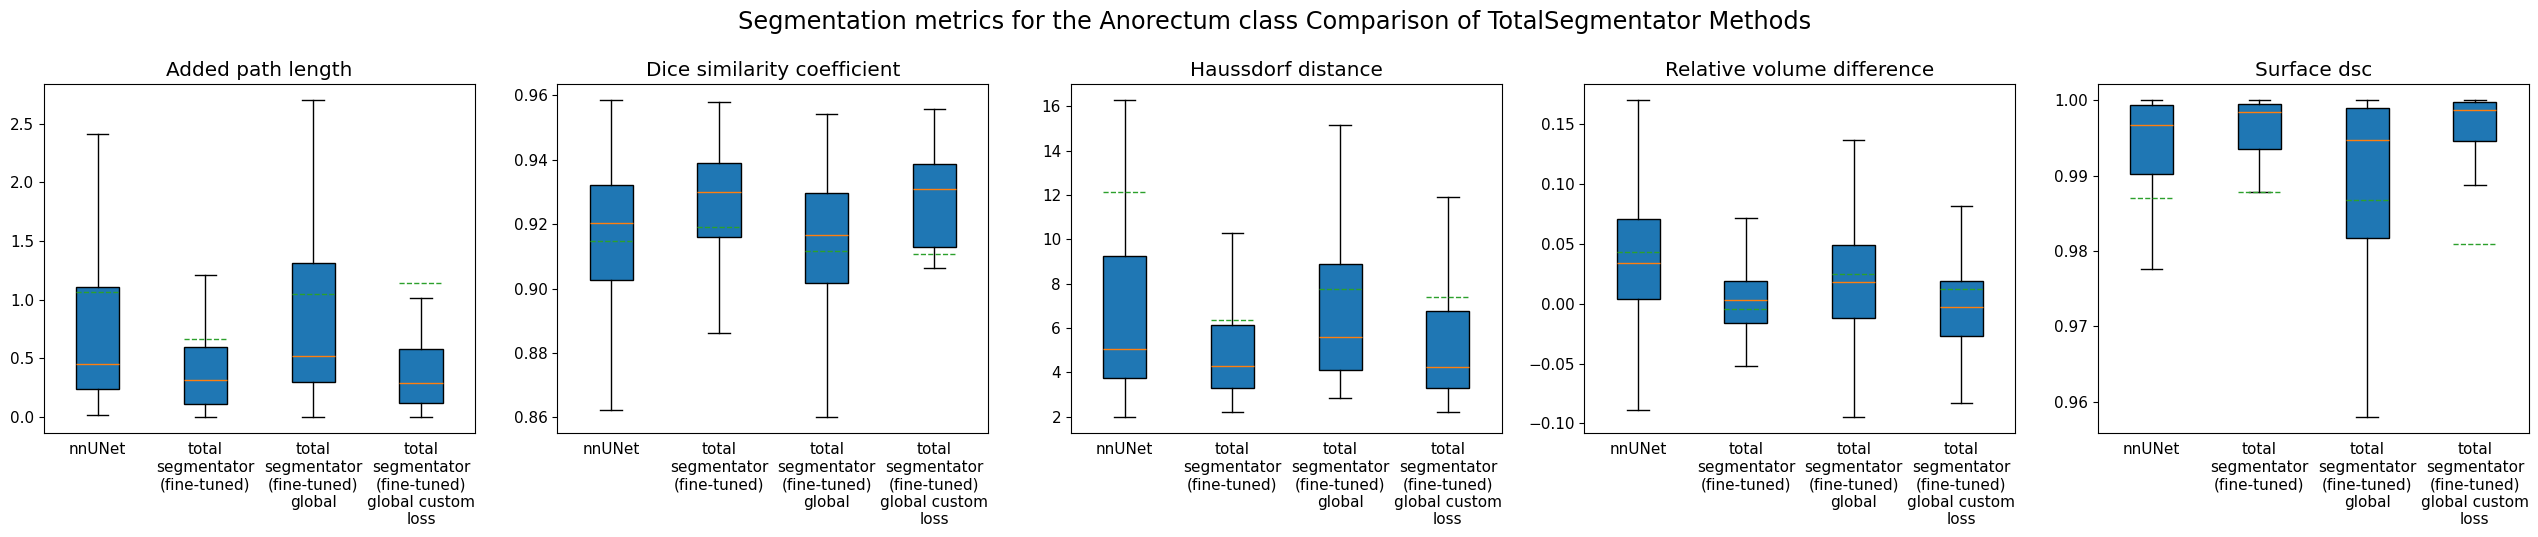

------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


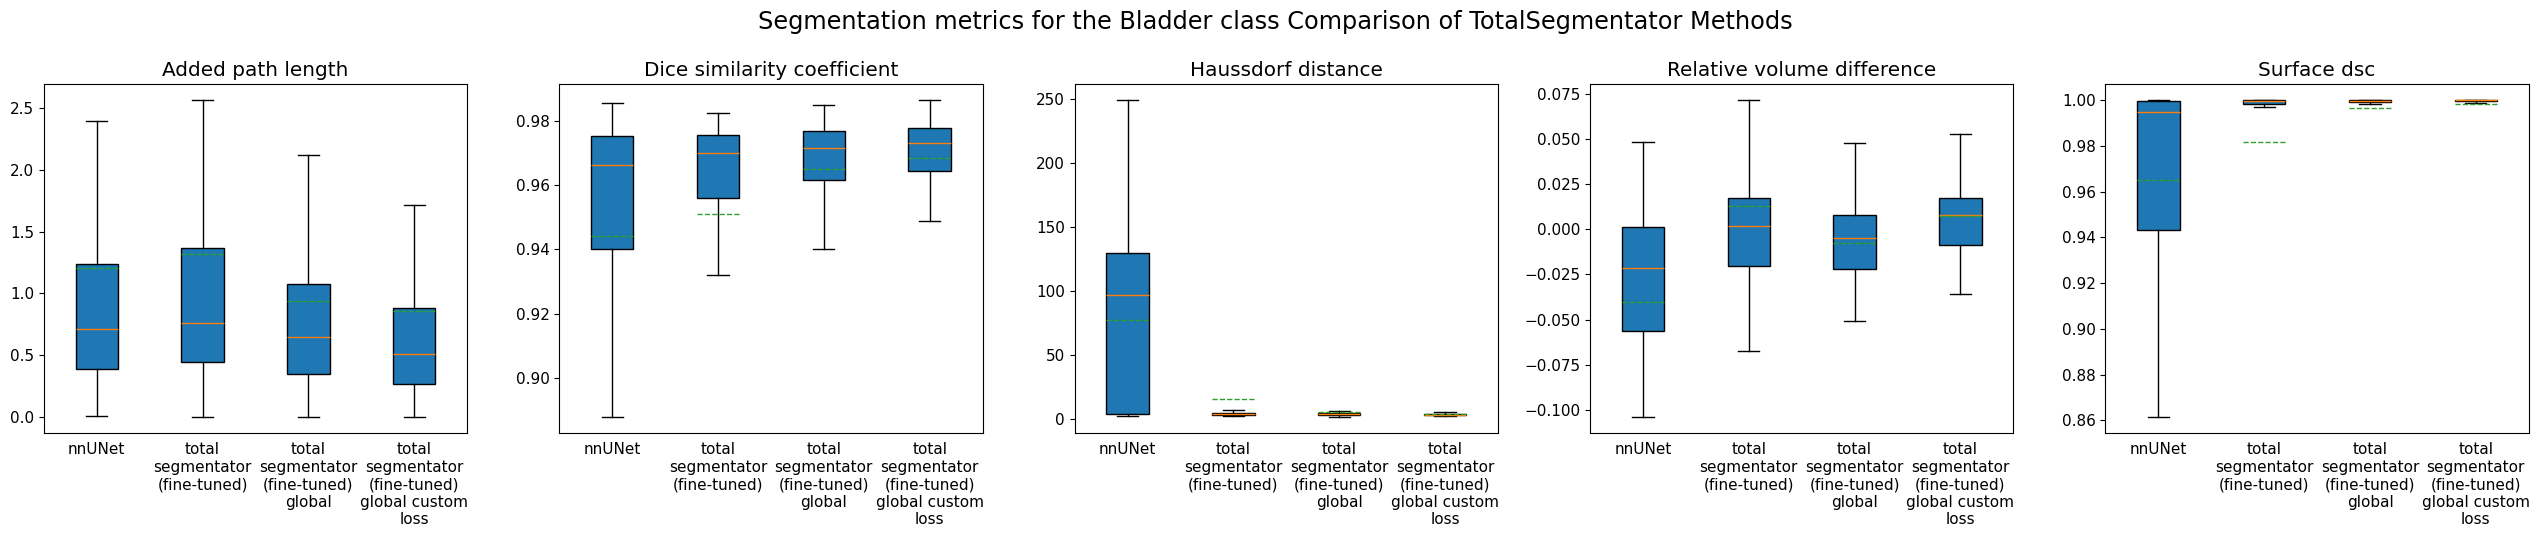

------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


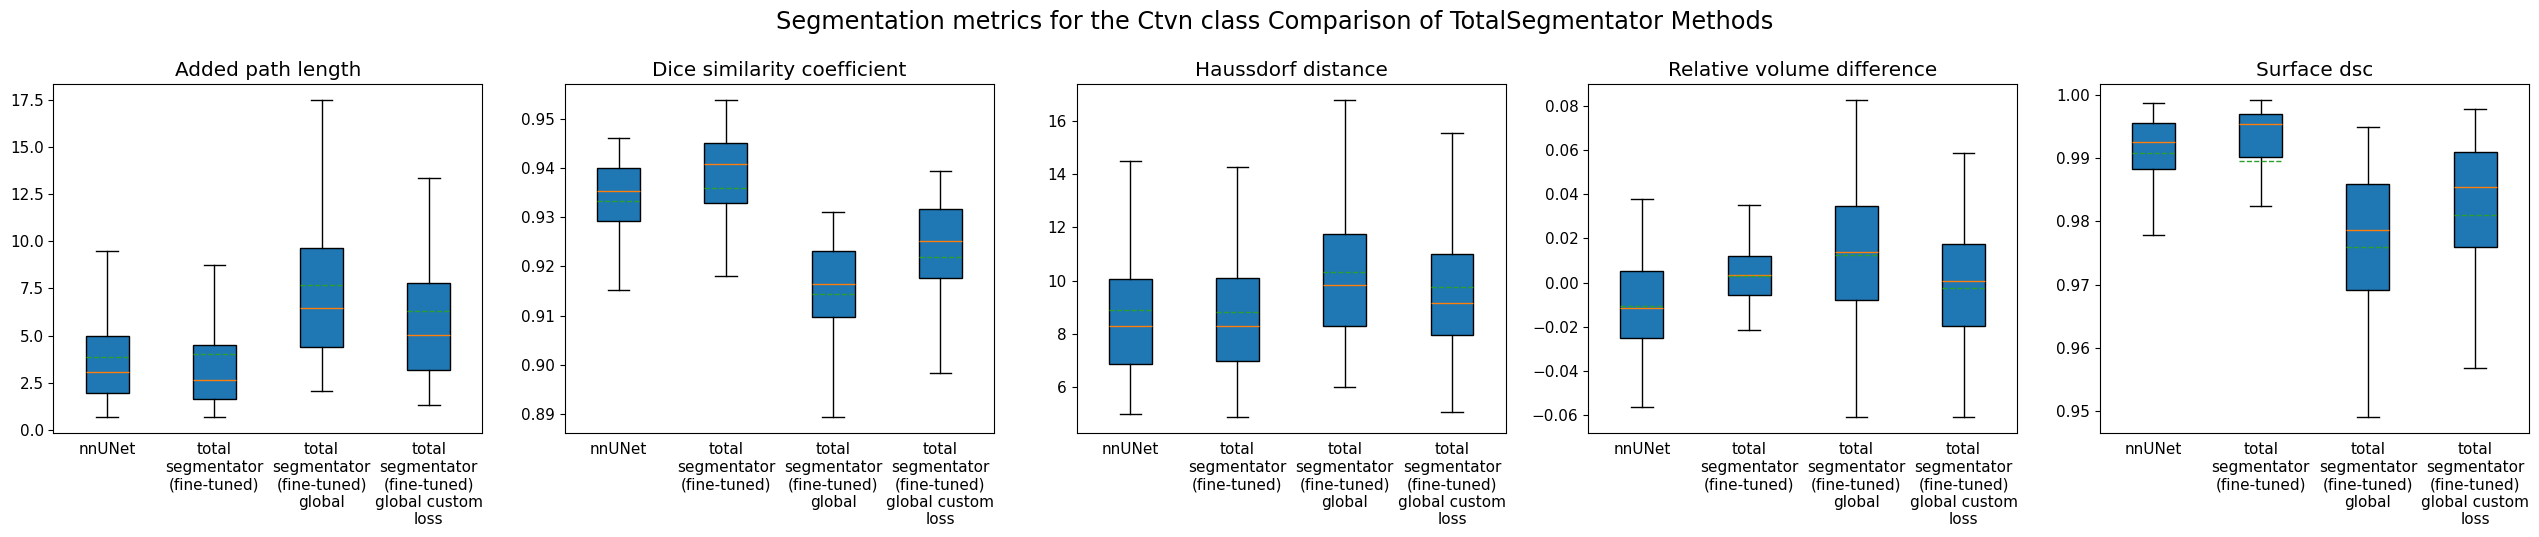

------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


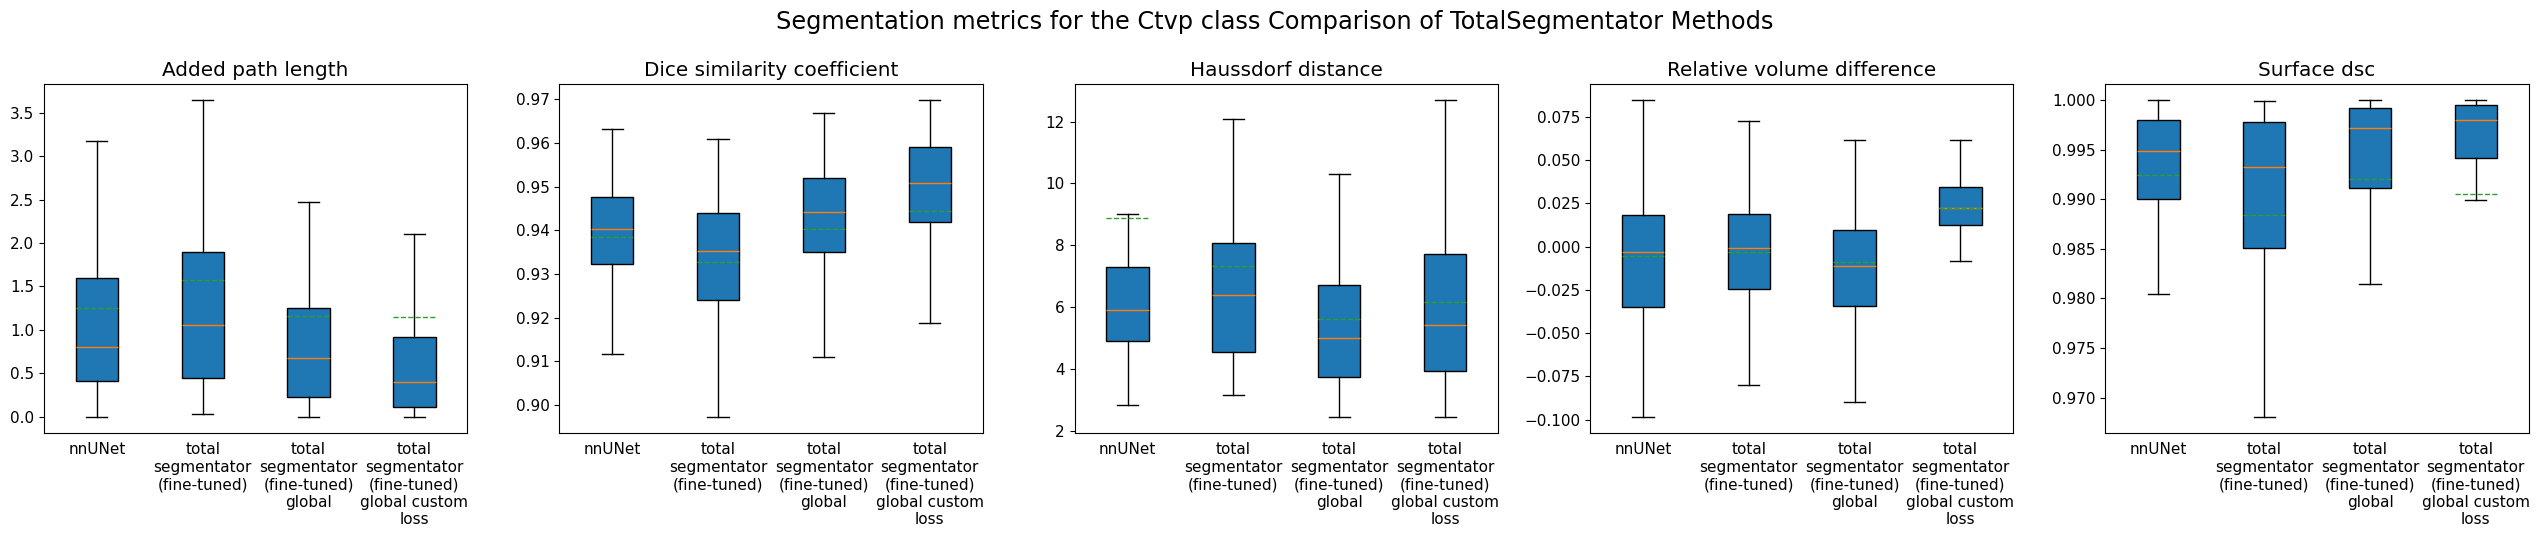

------------------------------------
Fetching metrics for  Dataset005_Parametrium  id  5
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


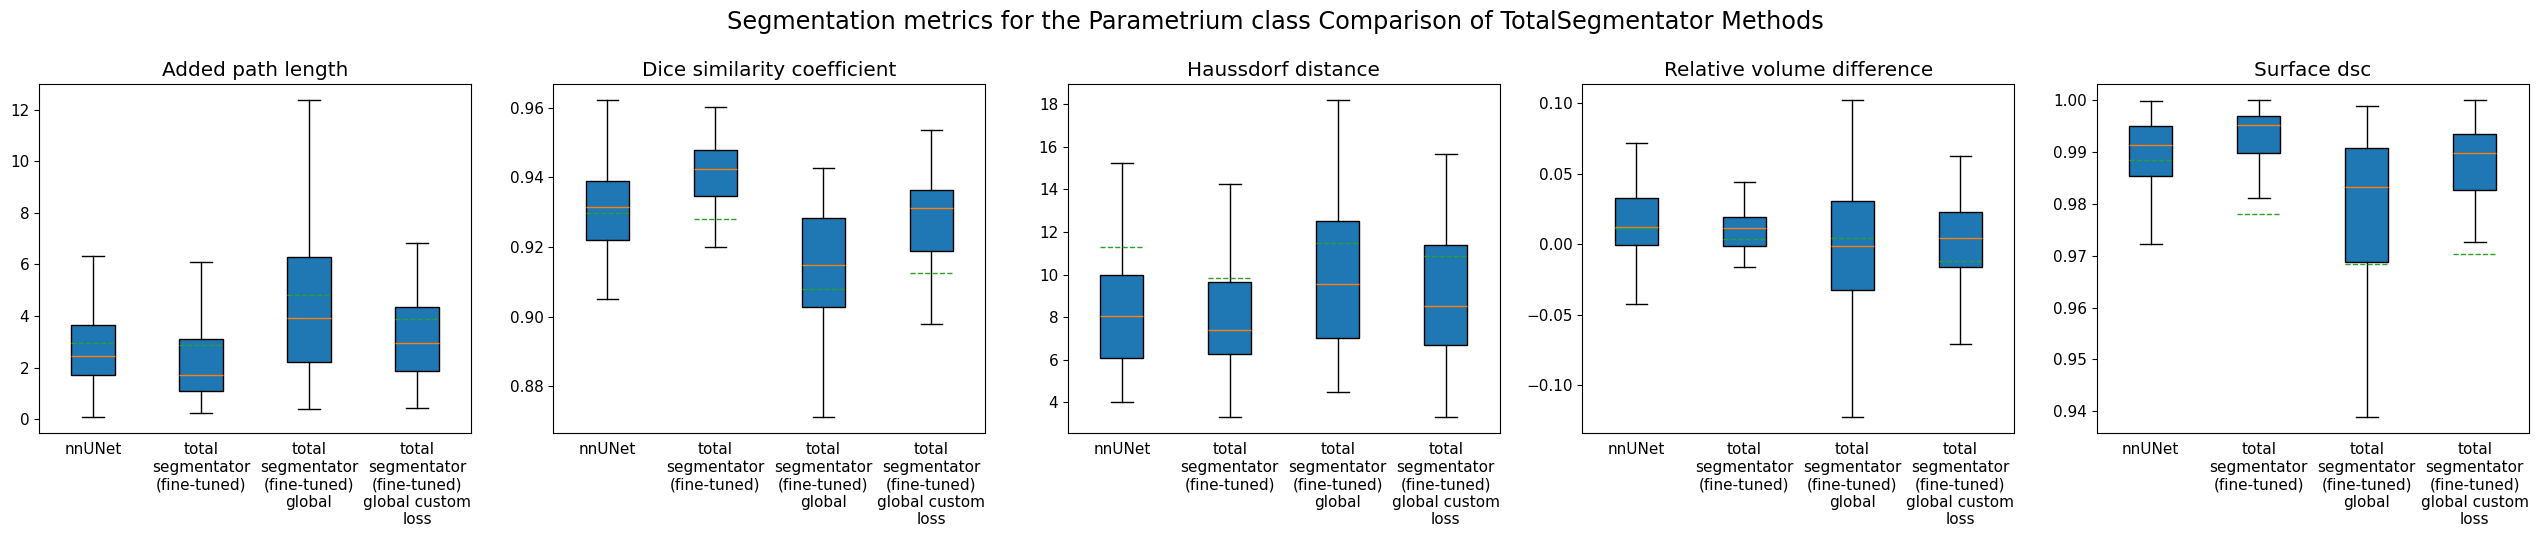

------------------------------------
Fetching metrics for  Dataset006_Uterus  id  6
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


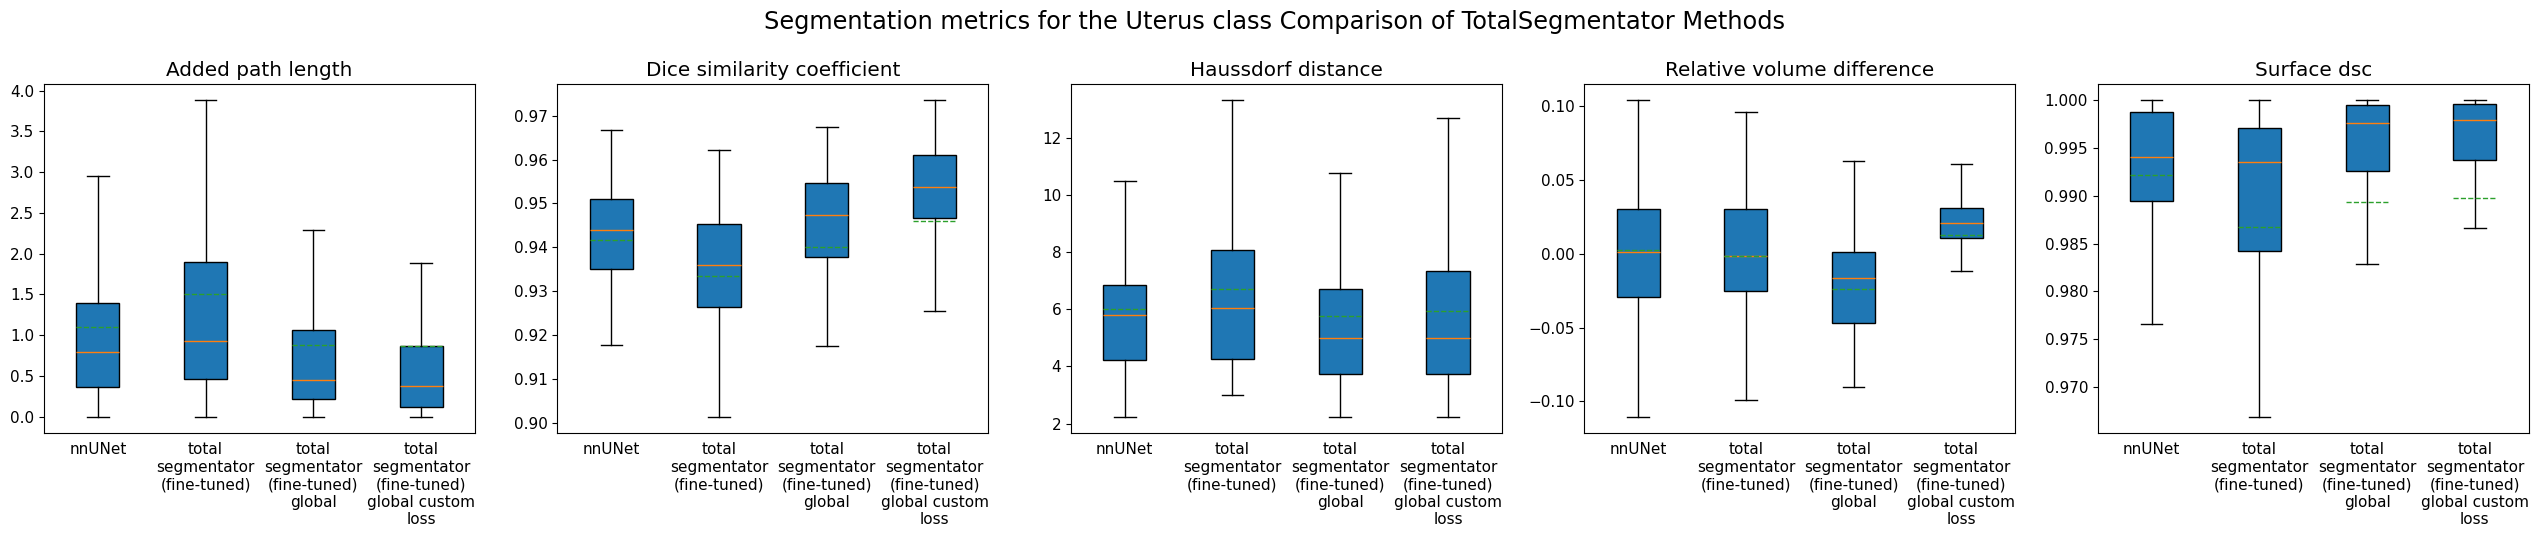

------------------------------------
Fetching metrics for  Dataset007_Vagina  id  7
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss


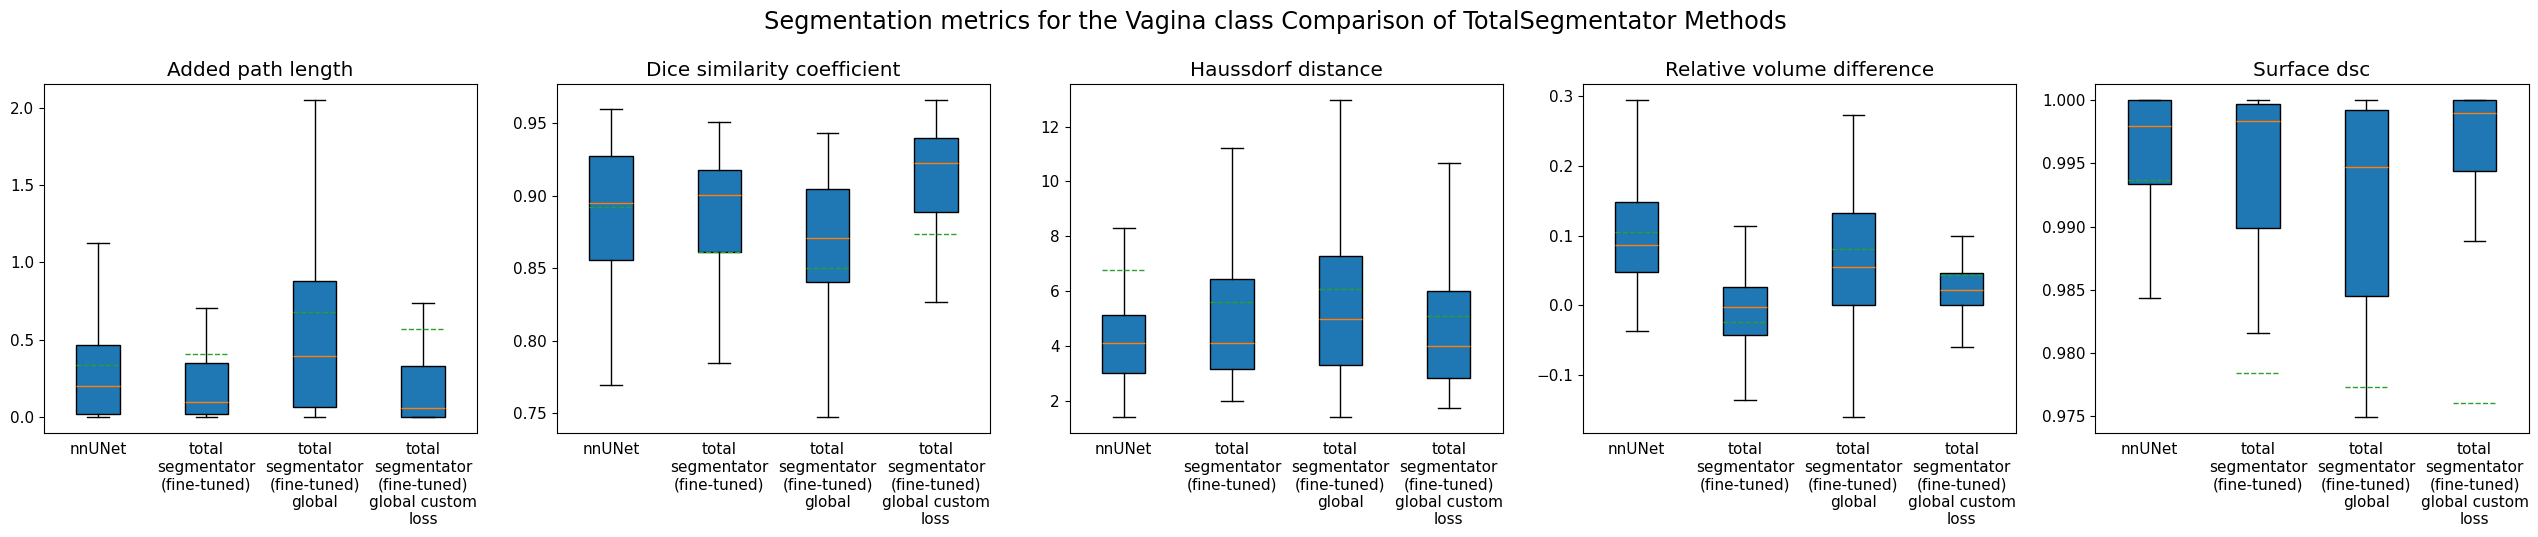

------------------------------------


In [100]:
for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    gt_path = os.path.join(os.environ.get('nnUNet_raw'), c, os.environ.get('data_trainingLabels'))
    
    prediction = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), c, 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), c, 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned) global custom loss': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainerCervical_500epochs__totseg_nnUNetPlans__3d_fullres'),
    }
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = calculate_metrics(gt_path, prediction, id - 1)
    plot_metrics(metrics, c, save=True, separate=separate, table=False, showfliers=False, additional_title_context='Comparison of TotalSegmentator Methods')
    print('------------------------------------')

### Plot for MedSAM

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet


KeyboardInterrupt: 

<Figure size 2240x520 with 0 Axes>

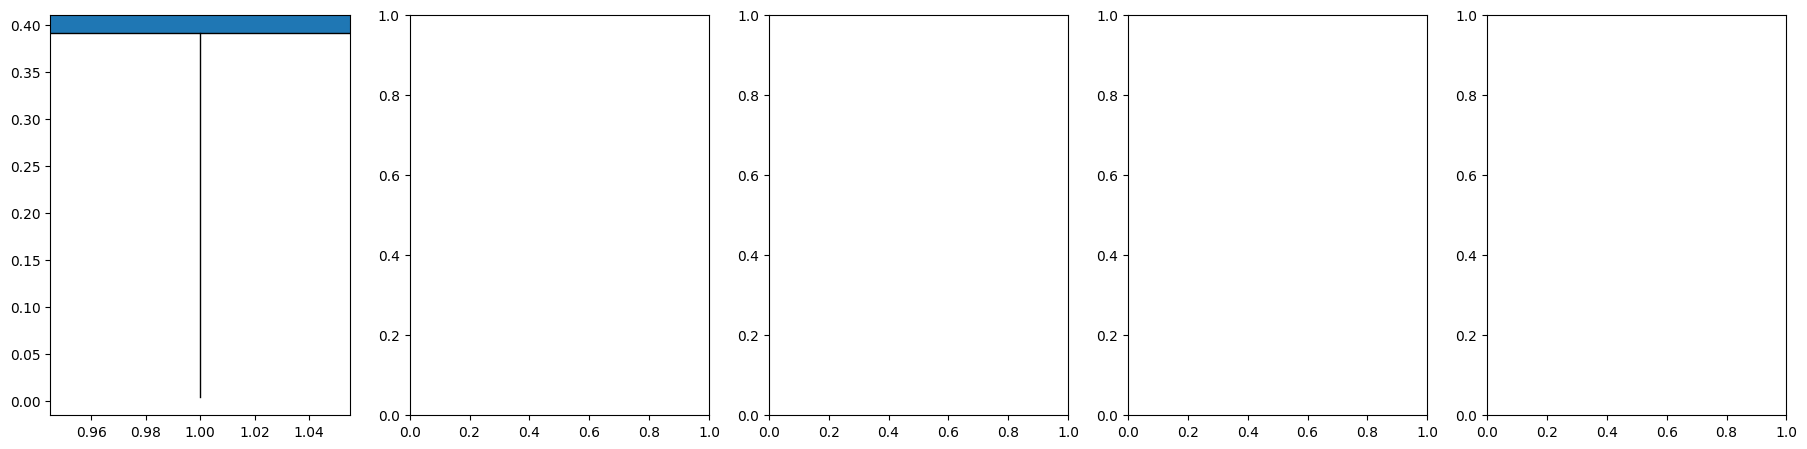

In [97]:
save = True

include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = True
include_UniverSeg = False
include_global = False

split_axis = False

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='MedSAM analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

In [14]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = True
include_UniverSeg = False
include_global = False

split_axis = True

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='MedSAM split analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset005_Parametrium  id  5
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset006_Uterus  id  6
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset007_Vagina  id  7
------------------------------

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

### UniverSeg

In [15]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = False
include_UniverSeg = True
include_global = False

split_axis = False

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='UniverSeg analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset005_Parametrium  id  5
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset006_Uterus  id  6
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset007_Vagina  id  7
------------------------------

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

In [16]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = False
include_UniverSeg = True

split_axis = True

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='UniverSeg split analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset005_Parametrium  id  5
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset006_Uterus  id  6
------------------------------------
Calculating metrics for  nnUNet
------------------------------------
Fetching metrics for  Dataset007_Vagina  id  7
------------------------------

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

<Figure size 9360x520 with 0 Axes>

### TotalSegmentator

In [17]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = True
include_MedSAM = False
include_UniverSeg = False
include_global = False

split_axis = False
table = True

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='TotalSegmentator analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator
Calculating metrics for  total segmentator (fine-tuned)
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  total segmentator (fine-tuned)
------------------------------------
Fetching metrics for  Dataset005_Parametrium  id  5
------------------------------------
Calculating metrics for  nnUNet


<Figure size 1920x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 1920x520 with 0 Axes>

<Figure size 1920x520 with 0 Axes>

<Figure size 1920x520 with 0 Axes>

<Figure size 1920x520 with 0 Axes>

<Figure size 1920x520 with 0 Axes>

### TotalBinary

In [18]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = False
include_UniverSeg = False
include_global = True

split_axis = True

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='Global analysis')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  nnUNet global custom loss
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  nnUNet global custom loss
Calculating metrics for  total segmentator (fine-tuned) global
Calculating metrics for  total segmentator (fine-tuned) global custom loss
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  nnUNet global custom loss
Calculating metrics for  total

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

<Figure size 3600x520 with 0 Axes>

## TotalBinary no custom loss

In [96]:
include_baseline = True
include_nnUNet = False
include_TotalSegmentator = False
include_MedSAM = False
include_UniverSeg = False
include_global = True
include_custom_loss = False

split_axis = True

for c in [
             os.environ.get('Anorectum'),
             os.environ.get('Bladder'),
             os.environ.get('CTVn'),
             os.environ.get('CTVp'),
             os.environ.get('Parametrium'),
             os.environ.get('Uterus'),
             os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    print('------------------------------------')
    metrics = fetch_metric_for_class(id)
    plot_metrics(metrics, c, save=save, separate=separate, table=table, showfliers=False, additional_title_context='Global analysis no custom loss')
    print('------------------------------------')

dump_and_reset_latex_table_aggregator()

Fetching metrics for  Dataset001_Anorectum  id  1
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  total segmentator (fine-tuned) global
------------------------------------
Fetching metrics for  Dataset002_Bladder  id  2
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  total segmentator (fine-tuned) global
------------------------------------
Fetching metrics for  Dataset003_CTVn  id  3
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  total segmentator (fine-tuned) global
------------------------------------
Fetching metrics for  Dataset004_CTVp  id  4
------------------------------------
Calculating metrics for  nnUNet
Calculating metrics for  nnUNet global
Calculating metrics for  total segmentator (fine-tuned) global
-----------------

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>

<Figure size 2240x520 with 0 Axes>